MAGIC gamma telescope data 2004 :
Dataset Information :

The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background).

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions.

The data set was generated by a Monte Carlo program, Corsika, described in D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers, Forschungszentrum Karlsruhe FZKA 6019 (1998). The program was run with parameters allowing to observe events with energies down to below 50 GeV.

Number of Instances: 19020

Number of Attributes: 11 (including the class)
Attribute information:

    fLength: continuous - major axis of ellipse [mm]
    fWidth: continuous - minor axis of ellipse [mm]
    fSize: continuous - 10-log of sum of content of all pixels [in #phot]
    fConc: continuous - ratio of sum of two highest pixels over fSize [ratio]
    fConc1: continuous - ratio of highest pixel over fSize [ratio]
    fAsym: continuous - distance from highest pixel to center, projected onto major axis [mm]
    fM3Long: continuous - 3rd root of third moment along major axis [mm]
    fM3Trans: continuous - 3rd root of third moment along minor axis [mm]
    fAlpha: continuous - angle of major axis with vector to origin [deg]
    fDist: continuous - distance from origin to center of ellipse [mm]
    class: g,h - gamma (signal), hadron (background)

Class Distribution:

g = gamma (signal): 12332 h = hadron (background): 6688

For technical reasons, the number of h events is underestimated. In the real data, the h class represents the majority of the events.

The simple classification accuracy is not meaningful for this data, since classifying a background event as signal is worse than classifying a signal event as background. For comparison of different classifiers an ROC curve has to be used. The relevant points on this curve are those, where the probability of accepting a background event as signal is below one of the following thresholds: 0.01, 0.02, 0.05, 0.1, 0.2 depending on the required quality of the sample of the accepted events for different experiments.

In [2]:
!pip install colorama

Defaulting to user installation because normal site-packages is not writeable


In [46]:
# Styling
from colorama import Fore, Back, Style

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing 
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection  import StratifiedKFold, cross_val_score
from sklearn.model_selection import KFold

#Model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier

#ensemble
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier

## acuracy and classification score and confusion matrix
# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [3]:
#telescope_path = 'https://raw.githubusercontent.com/uniqravi/AI_Dataset/master/telescope_data.csv'
telescope_path = '/Users/ravi/dataset/AI_Dataset/telescope_data.csv'

In [4]:
telescope_df = pd.read_csv(telescope_path)

In [10]:
telescope_df.head(5)

,Unnamed: 0,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


0    12332
1     6688
Name: class, dtype: int64

 G class % in data :  0.648370

 H class % in data :  0.351630


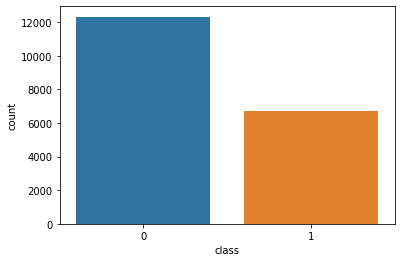

In [134]:
print(telescope_df['class'].value_counts())

sns.countplot(x='class',data=telescope_df)

perG = (telescope_df['class']==0).sum()/telescope_df.shape[0]
perH = (telescope_df['class']==1).sum()/telescope_df.shape[0]
print(Fore.GREEN+"\n G class % in data :",Fore.BLACK+" %f"%perG)
print(Fore.GREEN+"\n H class % in data :",Fore.BLACK+" %f"%perH)

As we can see, count of g class is 12332 and count of h class is 6688.In other word around 64 percent datapoints belong to class g and 35 percentage datapoint belong to class h.Difference between two class is around 34 percentage which clearly indicates that target values that we are going to predict, are imbalanced.

In [12]:
# looking insite data

#seems first column is kind of index
#dropping first column
telescope_df.columns

Index(['Unnamed: 0', 'fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
       'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class'],
      dtype='object')

In [5]:
telescope_df.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

In [14]:
telescope_df.shape

(19020, 11)

In [135]:
telescope_df.head(3)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,0


### Descriptive Analysis :

In [16]:
telescope_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fLength,19020.0,53.250154,42.364855,4.2835,24.336000,37.14770,70.122175,334.1770
fWidth,19020.0,22.180966,18.346056,0.0000,11.863800,17.13990,24.739475,256.3820
fSize,19020.0,2.825017,0.472599,1.9413,2.477100,2.73960,3.101600,5.3233
fConc,19020.0,0.380327,0.182813,0.0131,0.235800,0.35415,0.503700,0.8930
fConc1,19020.0,0.214657,0.110511,0.0003,0.128475,0.19650,0.285225,0.6752
fAsym,19020.0,-4.331745,59.206062,-457.9161,-20.586550,4.01305,24.063700,575.2407
fM3Long,19020.0,10.545545,51.000118,-331.7800,-12.842775,15.31410,35.837800,238.3210
fM3Trans,19020.0,0.249726,20.827439,-205.8947,-10.849375,0.66620,10.946425,179.8510
fAlpha,19020.0,27.645707,26.103621,0.0000,5.547925,17.67950,45.883550,90.0000
fDist,19020.0,193.818026,74.731787,1.2826,142.492250,191.85145,240.563825,495.5610


 <b> Mean value of are features varies a lot. that means all feature are not in same scale.
 <b> There are lot of outlier in features

In [136]:
#check missing value or non numeric column
print(Fore.GREEN+"\n checking missing value ")
print(Style.RESET_ALL)
print(telescope_df.isnull().sum())


 checking missing value 

fLength     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64


In [18]:
telescope_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [6]:
#Label encoder
telescope_df['class']=telescope_df['class'].astype('category').cat.codes

In [20]:
telescope_df.head(1)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.011,-8.2027,40.092,81.8828,0


<Figure size 1440x1296 with 0 Axes>

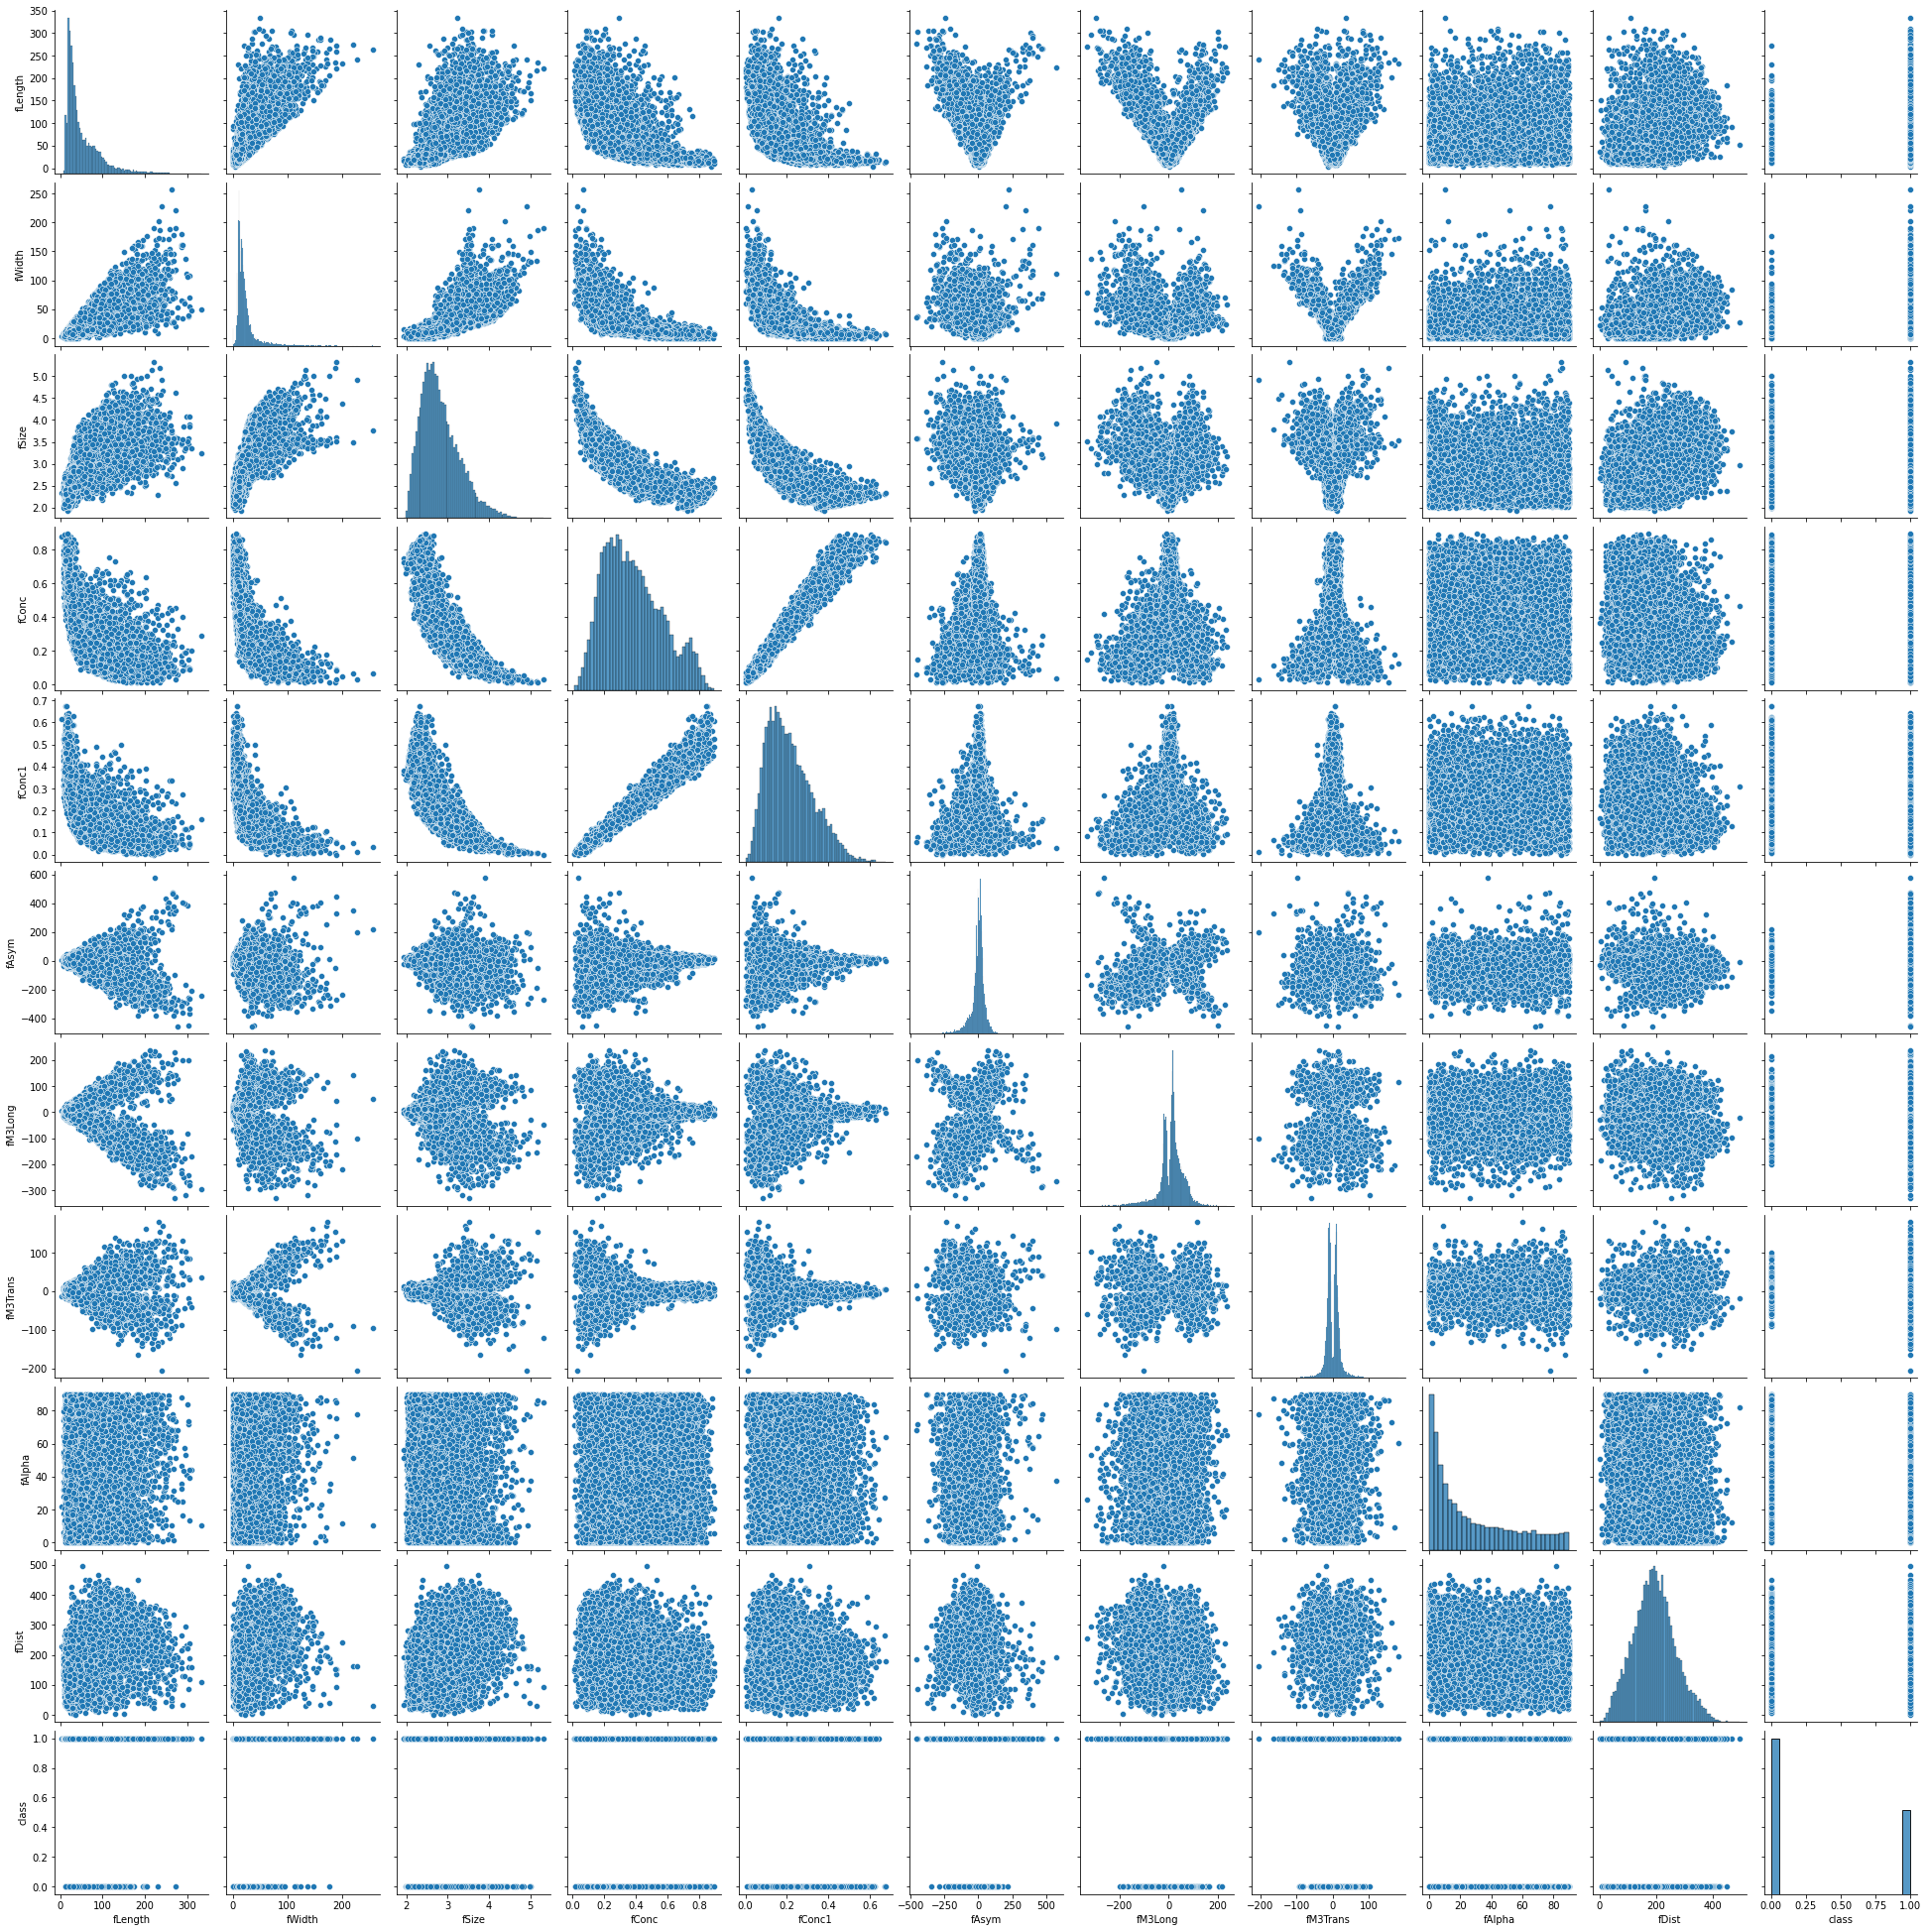

In [22]:
plt.figure(figsize=(20, 18))
sns.pairplot(telescope_df)

### Conculsion after Pairplot

> 1. As we can see features or attributes are not lenear independent. All of them somehow interrelated. It is not favourable condition for lenear model.
> 2. Feature are not normal distributed. some of them are in right skewed.



### Preprossesing

In [23]:
# finding number of outliner 
Q1 = telescope_df.quantile(0.25)
Q3 = telescope_df.quantile(0.75)
IQR = Q3 - Q1

In [24]:
print(Fore.GREEN+"\n Number of outliner ")
print(Style.RESET_ALL)
outlinerNum=((telescope_df < (Q1 - 1.5 * IQR)) | (telescope_df > (Q3 + 1.5 * IQR))).sum()
print(outlinerNum)
print(Style.RESET_ALL)
print(Fore.GREEN+"\n Max Number of Outliner "+str(outlinerNum.max()))
print(Style.RESET_ALL)
print(Fore.GREEN+"\n Percentage outliner "+str(outlinerNum.max()/(telescope_df.shape[0])*100))


 Number of outliner 

fLength      971
fWidth      1546
fSize        367
fConc          0
fConc1       150
fAsym       1781
fM3Long     1218
fM3Trans     850
fAlpha         0
fDist        128
class          0
dtype: int64


 Max Number of Outliner 1781


 Percentage outliner 9.363827549947423


In [139]:
#train and test split
X=telescope_df.iloc[:,0:10]
Y=telescope_df.iloc[:,-1]
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.25, random_state=10)

In [140]:
# choosing RobustScaler beacuse Data contains may feature with outlier.
robust=RobustScaler()
scaledXTrain=robust.fit_transform(X_train)
scaledXTest=robust.transform(X_test)

### Model Design Tuning and Testing

In [137]:
# Test options and evaluation metric
num_folds = 10
seed = 7
#scoring = 'mean_squared_error'

In [11]:
pipeLines = []
pipeLines.append(("logistic",Pipeline([('Scaler', RobustScaler()),("Logistic",LogisticRegression())])))
pipeLines.append(("svc",Pipeline([('Scaler', RobustScaler()),("SVC",SVC())])))
pipeLines.append(("knn",Pipeline([('Scaler', RobustScaler()),("KNN",KNeighborsClassifier())])))
pipeLines.append(("gaussianNB",Pipeline([('Scaler', RobustScaler()),("GaussianNB",GaussianNB())])))
pipeLines.append(("bernauliNB",Pipeline([('Scaler', RobustScaler()),("BernauliNB",BernoulliNB())])))

In [27]:
def executePipelineModels(pipeLines) :
    results = []
    names = []
    for name,model in pipeLines :
        kfold=StratifiedKFold(n_splits=num_folds,random_state=seed,shuffle=True)
        cv_results=cross_val_score(model,X_train,y_train,cv=kfold)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    return results,names

In [28]:
results,names = executePipelineModels(pipeLines)

logistic: 0.794532 (0.005872)
svc: 0.871433 (0.007003)
knn: 0.836523 (0.004881)
gaussianNB: 0.728917 (0.009666)
bernauliNB: 0.769999 (0.010296)


 At first glance to check the perfomance of different algorithm, all algorithms are executed with default hyper parameter. Listed below observations :   
 
 Support vector machine and Knn are performing very well.
 
 Naive naive_bayes and logistic are not worst because features are not indepedent to each other.

#### Tuning SVM 

In [14]:
# SVC model
parameter = {'C':[0.1,1,10],'gamma': [1,0.1],'kernel':['rbf','poly','sigmoid']}
#kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
cs = [0.1,1,10]
gammas = [1,0.1]
kernal=['rbf','poly','sigmoid']
resul=[]
for kr in kernal :
    for g in gammas :
        for c in cs :
            svc = SVC(C=c,kernel=kr,gamma=g)
            svc.fit(scaledXTrain,y_train)
            y_pred=svc.predict(scaledXTest);
            acc_AB = accuracy_score(y_test, y_pred)
            resul.append(acc_AB)
            print("kernal: %s, gamma: %s,C: %s,Accuracy Score :%s"% (kernal,g,c,acc_AB))
#grid = GridSearchCV(estimator=SVC(), param_grid=parameter, cv=kfold)
#grid_result = grid.fit(scaledXTrain, y_train)
#print(grid.best_params_)

0.83869610935857
0.8603575184016824
0.8614090431125131
0.8399579390115668
0.8586750788643533
0.8635120925341746
0.8321766561514196
0.8349106203995794
0.8372239747634069
0.7592008412197687
0.804416403785489
0.8267087276550998
0.5692954784437434
0.5680336487907466
0.5680336487907466
0.5882229232386961
0.5783385909568874
0.5781282860147213


In [15]:
# best svc hyper parameter is C=10,gamma=0.1 and kernal =rbf
svc = SVC(C=10,kernel='rbf',gamma=0.1)
pip=Pipeline([('Scaler', RobustScaler()),("SVC",svc)])
pip.fit(X_train,y_train)
y_pred=pip.predict(X_test)

In [22]:
print(Fore.GREEN+"\n SVM Accuracy : ", Fore.BLACK+"",accuracy_score(y_test, y_pred))
print(Style.RESET_ALL)
print(Fore.GREEN+"\n SVM Classification Report :")
print(Style.RESET_ALL)
print(classification_report(y_test,y_pred))


 SVM Accuracy :   0.8635120925341746


 SVM Classification Report :

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      3054
           1       0.91      0.69      0.78      1701

    accuracy                           0.86      4755
   macro avg       0.88      0.82      0.84      4755
weighted avg       0.87      0.86      0.86      4755



#### Moving to Decision Tree :

because decision tree does not affected by outlier and distribution of dataset.

In [23]:
decisionT=DecisionTreeClassifier(criterion='entropy',  # 1
                                splitter='best',     # 3
                                max_depth=5,       # 2
                                min_samples_split=2,  
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features=None,
                                random_state=None,
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                class_weight=None,
                                presort='deprecated',
                                ccp_alpha=0.0)
pip=Pipeline([('Scaler', RobustScaler()),("SVC",decisionT)])
pip.fit(X_train,y_train)
y_pred=pip.predict(X_test)

In [24]:
print(Fore.GREEN+"\n Decision Accuracy : ", Fore.BLACK+"",accuracy_score(y_test, y_pred))
print(Style.RESET_ALL)
print(Fore.GREEN+"\n Decision Classification Report :")
print(Style.RESET_ALL)
print(classification_report(y_test,y_pred))


 Decision Accuracy :   0.8153522607781283


 Decision Classification Report :

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      3054
           1       0.79      0.66      0.72      1701

    accuracy                           0.82      4755
   macro avg       0.81      0.78      0.79      4755
weighted avg       0.81      0.82      0.81      4755



#### Ensembles Method : 

Boosting Method : often considers homogeneous weak learner learns them sequetially in a very adaptive way (a base model depends upon previous model output weightage ) 

Here, Using AdaBoostClassfier

Bagging Method : often consinders homogenous weak learner learns them independetly from each other in parallel and combines them descritive averaging process.

Here, Bagging Classfier and RandomForest 

In [42]:
# ensembles
ensembles = []
ensembles.append(('adaboost', Pipeline([('Scaler', RobustScaler()),('AB', AdaBoostClassifier())])))
ensembles.append(('randomForest', Pipeline([('Scaler', RobustScaler()),('RF', RandomForestClassifier())])))

In [43]:
results,names = executePipelineModels(ensembles)

adaboost: 0.842761 (0.006707)
randomForest: 0.879847 (0.006488)



Random Forest perfoming well. Let's tune Random forest more.


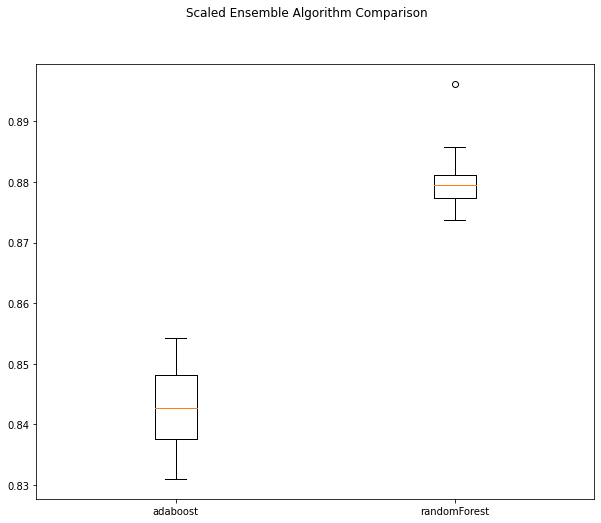

In [38]:
# Compare Algorithms
fig = plt.figure(figsize=(10,8))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [116]:
# Number of trees in random forest
n_estimators = np.arange(100,1000,100)   # returns evenly spaced 10 numbers
n_estimators=np.append(n_estimators,[[50]],)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
      #max_depth = [int(x) for x in np.linspace(5, 10, num = 2)]  # returns evenly spaced numbers can be changed to any
      #max_depth.append(None)
# Minimum number of samples required to split a node
       #min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
       #min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
                #'bootstrap': bootstrap
              }

In [117]:
n_estimators

array([100, 200, 300, 400, 500, 600, 700, 800, 900,  50])

In [118]:
kfold=StratifiedKFold(n_splits=num_folds,random_state=seed,shuffle=True)
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=random_grid,
                              n_iter =5, scoring='neg_mean_absolute_error', 
                              cv = kfold, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(scaledXTrain, y_train)
rf_random.best_params_

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.5min finished


{'n_estimators': 800, 'max_features': 'sqrt'}

In [119]:
# Testing data

best_random = rf_random.best_estimator_
Rand_search_cv=best_random.score(scaledXTest , y_test)*100

print("Random sarch CV Score:",Rand_search_cv,"%")

#print("\n\nRandom Forest Accuracy",RF_Test,"%\n\n")

# improvement=Rand_search_cv-(100*RF_Test)
#print("Accuracy improvement:",np.around(improvement),"%")

Random sarch CV Score: 87.21345951629863 %


In [122]:
rf_final=RandomForestClassifier(n_estimators=800,
                                ## criterion='gini',
                                 #min_samples_split=10,
                                 #min_samples_leaf=2,
                                 max_features='sqrt',
                                 #max_depth=None,
                                 #bootstrap=False
                                )
pip=Pipeline([('Scaler', RobustScaler()),("RF",rf_final)])
pip.fit(X_train,y_train)
y_pred=pip.predict(X_test)

In [123]:
print(Fore.GREEN+"\n Random Forest Accuracy : ", Fore.BLACK+"",accuracy_score(y_test, y_pred))
print(Style.RESET_ALL)
print(Fore.GREEN+"\n RF Classification Report :")
print(Style.RESET_ALL)
print(classification_report(y_test,y_pred))


 Random Forest Accuracy :   0.8721345951629863


 RF Classification Report :

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3054
           1       0.88      0.74      0.81      1701

    accuracy                           0.87      4755
   macro avg       0.87      0.84      0.86      4755
weighted avg       0.87      0.87      0.87      4755



In [128]:
svc = SVC(C=100,kernel='rbf',gamma=0.1)
begging=BaggingClassifier(base_estimator=svc,n_estimators=10)
pip=Pipeline([('Scaler', RobustScaler()),("RF",begging)])
pip.fit(X_train,y_train)
y_pred=pip.predict(X_test)

In [129]:
print(Fore.GREEN+"\n Bagging SVM Accuracy : ", Fore.BLACK+"",accuracy_score(y_test, y_pred))
print(Style.RESET_ALL)
print(Fore.GREEN+"\n Bagging SVM Classification Report :")
print(Style.RESET_ALL)
print(classification_report(y_test,y_pred))


 Bagging SVM Accuracy :   0.8658254468980021


 Bagging SVM Classification Report :

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      3054
           1       0.90      0.70      0.79      1701

    accuracy                           0.87      4755
   macro avg       0.88      0.83      0.85      4755
weighted avg       0.87      0.87      0.86      4755



### Conclusion :

Best accuacy and recall and precision are being preformed with RandomForest.